<h1 align="center"><font size="5">RECOMMENDATION SYSTEM WITH A RESTRICTED BOLTZMANN MACHINE</font></h1>

In this notebook, we will go over the usage of Restricted Boltzmann Machine in a Collaborative Filtering based recommendation system. Our program will be able to recommend items by trying to find users that are similar to each other based on the given ratings. TensorFlow library is used.

<h2>Table of Contents</h2>

<ol>
    <li><a href="#ref1">Importing the Libraries</a></li>
    <li><a href="#ref2">Loading in the Data</a></li>
    <li><a href="#ref3">The Algorithm</a></li>
    <li><a href="#ref4">Setting the Model's Parameters</a></li>
    <li><a href="#ref5">Recommendation</a></li>
</ol>
<br>
<br>
<hr>

<a id="ref1"></a>
<h2>Importing the Libraries</h2>

We will be using Tensorflow and Numpy to build the algorithms for Restricted Boltzmann Machines and Pandas to modify the database.

In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

<hr>

<a id="ref2"></a>
<h2>Loading in the Data</h2>

We will be using dataset by acquired by GroupLens from the MovieLens website. Movies and ratings datasets is stored in the dataset folder. We use Pandas to load our data and we let it know to seperate data points at every '::' by specifying <code>sep='::'</code> parameter. 

We also specified <code>header=None</code> parameter because our file does not contain any headers.

In [25]:
#Loading in the movies dataset
movies_df = pd.read_csv('dataset/ml-1m/movies.dat', sep='::', header=None, engine='python', encoding='latin-1')

#Loading in the ratings dataset
ratings_df = pd.read_csv('dataset/ml-1m/ratings.dat', sep='::', header=None, engine='python', encoding='latin-1')

Lets take a look at the first five columns of movies dataset.

In [26]:
movies_df.head()

,0,1,2
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Lets take a look at the first five columns of ratings dataset.

In [27]:
ratings_df.head()

,0,1,2,3
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


Our <b>movies_df</b> contains dataframe that stores movie's ID number, title and genres. Our <b>ratings_df</b> variable stores User ID number, movie's ID number that the user has watched and user's rating for the specific movie. We will rename dataframe in the next lines.

In [28]:
movies_df.columns = ['MovieID', 'Title', 'Genres']
movies_df.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


And our final ratings_df:

In [29]:
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
ratings_df.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


<hr>

<a id="ref3"></a>
<h2>The Algorithm</h2>

Restricted Boltzmann Machine has two layers of neurons, a visible input later and hidden layer. Hidden layer will be used to learn properties from the data fed through the input layer. The model we will build ahead will contain N neurons, where N is the number of movies in  the dataset. Each neuron will store a normalized rating value varying from 0 to 1, where 0 means that person has not watched the movie and 1 meaning the person likes the movie more. 

After we pass the input, we will have hidden layer to learn its features. By recontructing the input, we will be able to predict the ratings for movies that user has not watched.

<h3>Formatting the Data</h3>

First we will start by formatting the data by storing the normalized users ratings into as matrix of user-rating and normalize the values. Matrix of user rating is called trX.

In [30]:
user_rating_df = ratings_df.pivot(index='UserID', columns='MovieID', values='Rating')
user_rating_df.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
UserID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Lets normalize it now:

In [31]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

<hr>

<a id="ref4"></a>
<h2>Setting the Model's Parameters</h2>

We will now start crating variables for storing our visible layer biases, hidden layer biases and weights that will connect visible layer to the hidden layer. We will also set the number of hidden layers to 16, but it can modified for testing purposes.

In [32]:
hiddenUnits = 20
visibleUnits =  len(user_rating_df.columns)

vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) #Number of unique movies

hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) #Number of features we're going to learn

W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32)

Now we add the activation functions <code>tf.sigmoid</code> and <code>tf.relu</code> because they are commonly used for RBMs, and continue with defining a function to return only the generated hidden states for the hidden layer and also for the reconstructed output.

In [33]:
v0 = tf.zeros([visibleUnits], tf.float32)
#testing to see if the matrix product works
tf.matmul([v0], W)

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [34]:
#Input 
#defining a function to return only the generated hidden states 
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)  #probabilities of the hidden units
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) 
    return h0_state

h0 = hidden_layer(v0, W, hb)

def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob))))
    return v1_state[0]


v1 = reconstructed_output(h0, W, vb)
print("hidden state shape: ", h0.shape)
print("v0 state shape:  ", v0.shape)
print("v1 state shape:  ", v1.shape)

hidden state shape:  (1, 20)
v0 state shape:   (3706,)
v1 state shape:   (3706,)


And set the error function, which will be the Mean Absolute Error Function.

In [35]:
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

err = tf.reduce_mean(tf.square(v0 - v1))
print("error" , err.numpy())

error 0.49622235


Now we train the RBM with 5 epochs with each epoch using a batchsize of 500, giving 12 batches. After training, we print out a graph with the error by epoch.

Epoch: 1 batch #: 0  of 12 sample #: 499 reconstruction error: 0.045559
Epoch: 1 batch #: 1  of 12 sample #: 499 reconstruction error: 0.027588
Epoch: 1 batch #: 2  of 12 sample #: 499 reconstruction error: 0.044145
Epoch: 1 batch #: 3  of 12 sample #: 499 reconstruction error: 0.034215
Epoch: 1 batch #: 4  of 12 sample #: 499 reconstruction error: 0.039870
Epoch: 1 batch #: 5  of 12 sample #: 499 reconstruction error: 0.035154
Epoch: 1 batch #: 6  of 12 sample #: 499 reconstruction error: 0.024663
Epoch: 1 batch #: 7  of 12 sample #: 499 reconstruction error: 0.015758
Epoch: 1 batch #: 8  of 12 sample #: 499 reconstruction error: 0.005753
Epoch: 1 batch #: 9  of 12 sample #: 499 reconstruction error: 0.113222
Epoch: 1 batch #: 10  of 12 sample #: 499 reconstruction error: 0.022817
Epoch: 1 batch #: 11  of 12 sample #: 499 reconstruction error: 0.101457
Epoch: 1 batch #: 12  of 12 sample #: 39 reconstruction error: 0.077474
Epoch: 2 batch #: 0  of 12 sample #: 499 reconstruction error:

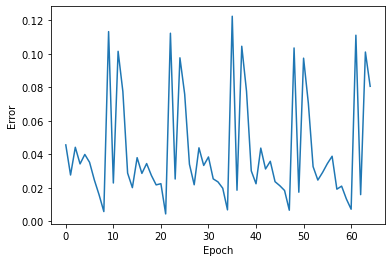

In [36]:
epochs = 5
batchsize = 500
errors = []
weights = []
K=1
alpha = 0.1

#creating datasets
train_ds = \
    tf.data.Dataset.from_tensor_slices((np.float32(trX))).batch(batchsize)

v0_state=v0
for epoch in range(epochs):
    batch_number = 0
    for batch_x in train_ds:

        for i_sample in range(len(batch_x)):           
            for k in range(K):
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)
                v1_state = reconstructed_output(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)

                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) 

                v0_state = v1_state

            if i_sample == len(batch_x)-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)
                print ( 'Epoch: %d' % (epoch + 1), 
                       "batch #: %i " % batch_number, "of %i" % (len(trX)/batchsize), 
                       "sample #: %i" % i_sample,
                       'reconstruction error: %f' % err)
        batch_number += 1

plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

<hr>

<a id="ref5"></a>
<h2>Recommendation</h2>

We can now predict which movies a randomly selected user might like. This can be accomplished by entering the preferences of the movies viewed by the user into the RBM and then reconstructing the entry. The values provided by the RBM attempt to estimate the user's preferences for movies he has not seen based on the preferences of the users for whom the RBM has been trained.

First we will select a mock user:

In [37]:
mock_user_id = 175

In [38]:
#Selecting the input user
inputUser = trX[mock_user_id-1].reshape(1, -1)

inputUser = tf.convert_to_tensor(trX[mock_user_id-1],"float32")
v0 = inputUser

print(v0)
v0.shape

tf.Tensor([0.8 0.  0.  ... 0.  0.  0. ], shape=(3706,), dtype=float32)


TensorShape([3706])

Now we feed in the user and reconstructing the input:

In [39]:
v0test = tf.zeros([visibleUnits], tf.float32)
v0test.shape

TensorShape([3706])

In [40]:
hh0 = tf.nn.sigmoid(tf.matmul([v0], W) + hb)

vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)

rec = vv1

tf.maximum(rec,1)
for i in vv1:
    print(i)

tf.Tensor([0.5745997  0.23516527 0.14686969 ... 0.01366231 0.00354254 0.045679  ], shape=(3706,), dtype=float32)


We can now list 16 movies that our mock user would like:

In [41]:
scored_movies_df_mock = movies_df[movies_df['MovieID'].isin(user_rating_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(16)

,MovieID,Title,Genres,RecommendationScore
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,"tf.Tensor(0.7650635, shape=(), dtype=float32)"
2327,2396,Shakespeare in Love (1998),Comedy|Romance,"tf.Tensor(0.73509824, shape=(), dtype=float32)"
2693,2762,"Sixth Sense, The (1999)",Thriller,"tf.Tensor(0.7272359, shape=(), dtype=float32)"
1220,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,"tf.Tensor(0.71922946, shape=(), dtype=float32)"
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,"tf.Tensor(0.6943728, shape=(), dtype=float32)"
315,318,"Shawshank Redemption, The (1994)",Drama,"tf.Tensor(0.6727482, shape=(), dtype=float32)"
1196,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller,"tf.Tensor(0.66833013, shape=(), dtype=float32)"
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,"tf.Tensor(0.6548991, shape=(), dtype=float32)"
1179,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance,"tf.Tensor(0.6503651, shape=(), dtype=float32)"
1081,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,"tf.Tensor(0.650365, shape=(), dtype=float32)"


So, how do we recommend movies that the user has not watched yet?

We filter it out and find all the movies that out mock user has watched before:

In [42]:
movies_df_mock = ratings_df[ratings_df['UserID'] == mock_user_id]

Now we will merge all the movies our mock user has watched with the predicted scores:

In [43]:
merged_df_mock = scored_movies_df_mock.merge(movies_df_mock, on='MovieID', how='outer')

lets sort it and take a look at the first 20 rows:

In [44]:
merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(16)

,MovieID,Title,Genres,RecommendationScore,UserID,Rating,Timestamp
253,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,"tf.Tensor(0.7650635, shape=(), dtype=float32)",175.0,5.0,977114390.0
2203,2396,Shakespeare in Love (1998),Comedy|Romance,"tf.Tensor(0.73509824, shape=(), dtype=float32)",175.0,5.0,977113261.0
2557,2762,"Sixth Sense, The (1999)",Thriller,"tf.Tensor(0.7272359, shape=(), dtype=float32)",175.0,4.0,978052038.0
1148,1240,"Terminator, The (1984)",Action|Sci-Fi|Thriller,"tf.Tensor(0.71922946, shape=(), dtype=float32)",NaN,NaN,NaN
1106,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,"tf.Tensor(0.6943728, shape=(), dtype=float32)",175.0,5.0,977114390.0
309,318,"Shawshank Redemption, The (1994)",Drama,"tf.Tensor(0.6727482, shape=(), dtype=float32)",175.0,5.0,977111380.0
1124,1214,Alien (1979),Action|Horror|Sci-Fi|Thriller,"tf.Tensor(0.66833013, shape=(), dtype=float32)",175.0,5.0,977114801.0
1120,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,"tf.Tensor(0.6548991, shape=(), dtype=float32)",175.0,5.0,977114436.0
1107,1197,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance,"tf.Tensor(0.6503651, shape=(), dtype=float32)",175.0,4.0,977114404.0
1025,1097,E.T. the Extra-Terrestrial (1982),Children's|Drama|Fantasy|Sci-Fi,"tf.Tensor(0.650365, shape=(), dtype=float32)",175.0,5.0,977112110.0


As you can see, there are some movies that user has not watched yet and has high score based on our model. So, we can recommend them to the user.

<hr>

Notebook has been built with the help of a tutorial written by <a href="https://developer.ibm.com/profiles/mohammad.fawaz.siddiqi/"> Mohammad Fawaz Siddiqi</a> called "Build a recommendation engine with a restricted Boltzmann machine using TensorFlow".